Multilabel classification refers to the scenario when each item can have more than one label. This is also a classification problem, but the way it is solved is slightly different:
- In the last layer of the network instead of softmax activation, sigmoid is used
- Instead of cross-entropy loss, binary cross entropy loss is used
- Instead of computing ROC, Confusion Matrix,  Hamming Loss, Multilabel Confusion Matrix

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms

In [2]:
import pandas as pd
import numpy as np

In [3]:
###### Naive reader ########
meta=pd.read_csv("data/miml_dataset/miml_labels_1.csv")
meta.head(2)

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0


In [4]:
(meta.drop('Filenames',axis=1).apply(lambda x:x.sum(),axis=1)>1).sum()/meta.shape[0]

0.2285

In [5]:
import PIL
import os
from tqdm.notebook import tqdm
base_path="data/miml_dataset/images"

In [6]:
#ulimit -n 4096
imgs=[PIL.Image.open(os.path.join(base_path,img)) for img in tqdm(meta['Filenames'])]

In [7]:
t=transforms.Compose([transforms.Resize((100,100)),
                   transforms.ToTensor()])

In [8]:
t(imgs[0]).shape

torch.Size([3, 100, 100])

In [9]:
Imgs=list(map(lambda x:t(x),imgs))

In [10]:
y=meta.drop("Filenames",axis=1).values

In [11]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [12]:
class Data(Dataset):
    def __init__(self,imgs,y):
        self.imgs=imgs
        self.y=y
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        x=self.imgs[idx]
        y=self.y[idx,]
        batch={'X':x,'y':y}
        return batch

In [13]:
data=Data(Imgs,y)

In [14]:
next(iter(data))['X'].shape

torch.Size([3, 100, 100])

In [15]:
d=DataLoader(data,batch_size=100,shuffle=True)

In [16]:
next(iter(d))['X'].shape

torch.Size([100, 3, 100, 100])

In [17]:
class MultiLabel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features=nn.Sequential(
                            nn.Conv2d(in_channels=3,
                            out_channels=32,
                            kernel_size=3,
                            padding=1,
                            stride=1),
                            
                            nn.ReLU(), 
                                    
                            nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            padding=1,
                            stride=1),
                                    
                            nn.ReLU(),
                                    
                            nn.MaxPool2d(kernel_size=2,
                              stride=2,
                              padding=0),
                            
                            nn.Dropout(0.25),
                            nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            padding=1,
                            stride=1),
                            
                           nn.ReLU(),
                            
                           nn.Conv2d(in_channels=64,
                           out_channels=64,
                           kernel_size=3,
                           padding=0,
                           stride=1),
                           
                           nn.MaxPool2d(kernel_size=3,
                              stride=2,
                              padding=0),
                           nn.Dropout(0.25))
        self.classifier=nn.Sequential(nn.Linear(self._flatten_dim(),512),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(512,5),
                                     nn.Sigmoid())

   

    def _flatten_dim(self):
        x=torch.randn(1,3,100,100)
        x=self.features(x)
        c=x.shape[1]
        h=x.shape[2]
        w=x.shape[3]
        return c*h*w
    
    def forward(self,X):
        X=self.features(X)
        X=X.view(X.shape[0],-1)
        X=self.classifier(X)
        return X

In [18]:
m=MultiLabel()

In [19]:
m(next(iter(d))['X']).shape

torch.Size([100, 5])

In [20]:
from torch import optim

In [21]:
opt=optim.Adam(m.parameters())

In [22]:
num_epochs=10
Loss=[]
for i in tqdm(list(range(num_epochs))):
    for j,batch in enumerate(d):
        X=batch['X'].float()
        y=batch['y'].float()
        preds=m(X)
        loss=nn.BCELoss()(preds,y)
        Loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        print(f"epoch: {i+1}, iter: {j+1}, loss {round(loss.item(),2)}")

epoch: 1, iter: 1, loss 0.7
epoch: 1, iter: 2, loss 0.79
epoch: 1, iter: 3, loss 0.58
epoch: 1, iter: 4, loss 0.6
epoch: 1, iter: 5, loss 0.55
epoch: 1, iter: 6, loss 0.56
epoch: 1, iter: 7, loss 0.58
epoch: 1, iter: 8, loss 0.56
epoch: 1, iter: 9, loss 0.56
epoch: 1, iter: 10, loss 0.54
epoch: 1, iter: 11, loss 0.55
epoch: 1, iter: 12, loss 0.55
epoch: 1, iter: 13, loss 0.54
epoch: 1, iter: 14, loss 0.52
epoch: 1, iter: 15, loss 0.52
epoch: 1, iter: 16, loss 0.5
epoch: 1, iter: 17, loss 0.48
epoch: 1, iter: 18, loss 0.52
epoch: 1, iter: 19, loss 0.5
epoch: 1, iter: 20, loss 0.48
epoch: 2, iter: 1, loss 0.55
epoch: 2, iter: 2, loss 0.46
epoch: 2, iter: 3, loss 0.48
epoch: 2, iter: 4, loss 0.47
epoch: 2, iter: 5, loss 0.45
epoch: 2, iter: 6, loss 0.47
epoch: 2, iter: 7, loss 0.43
epoch: 2, iter: 8, loss 0.42
epoch: 2, iter: 9, loss 0.43
epoch: 2, iter: 10, loss 0.46
epoch: 2, iter: 11, loss 0.43
epoch: 2, iter: 12, loss 0.43
epoch: 2, iter: 13, loss 0.39
epoch: 2, iter: 14, loss 0.38
ep

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

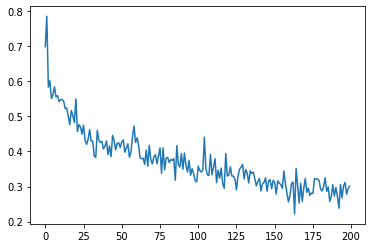

In [24]:
plt.plot(range(len(Loss)),Loss)

In [25]:
### torch.save(m.state_dict(),"data/multilabel.pth") save for later use, training takes a long time

In [44]:
D=DataLoader(data,batch_size=1)
preds=[]
acts=[]
for batch in tqdm(D):
    X=batch['X'].float()
    y=batch['y'].float()
    m.eval()
    with torch.no_grad():
        preds.append(m(X))
        acts.append(y)

In [45]:
(preds[0]>0.5).int()

tensor([[1, 0, 0, 0, 0]], dtype=torch.int32)

In [46]:
p=list(map(lambda x: (x>0.5).int().squeeze(0),preds))

In [47]:
p=list(map(lambda x:x.numpy(),p))

In [48]:
acts=list(map(lambda x:x.squeeze(0).numpy(),acts))

In [49]:
from sklearn.metrics import multilabel_confusion_matrix

In [52]:
multilabel_confusion_matrix(np.array(acts),np.array(p))

array([[[1521,   70],
        [  93,  316]],

       [[1471,   71],
        [ 155,  303]],

       [[1242,  178],
        [ 206,  374]],

       [[1504,   31],
        [  52,  413]],

       [[1349,   91],
        [ 137,  423]]])

In [64]:
from sklearn.metrics import hamming_loss

In [65]:
hamming_loss(np.array(acts),np.array(p)) ###The Hamming loss is the fraction of labels that are incorrectly predicted.

0.1084

In [66]:
scores=list(map(lambda x:x.squeeze(0).numpy(),preds))

In [67]:
from sklearn.metrics import coverage_error

In [68]:
coverage_error(np.array(acts),np.array(scores))

1.5455

In [69]:
from sklearn.metrics import label_ranking_average_precision_score

In [70]:
label_ranking_average_precision_score(np.array(acts),np.array(scores))
## For each ground truth label, what fraction of higher-ranked labels were true labels?

0.8989361111111109

In [71]:
from sklearn.metrics import label_ranking_loss
label_ranking_loss(np.array(acts),np.array(scores))
## function computes the ranking loss which averages over the samples the number of label pairs that are 
## incorrectly ordered, i.e. true labels have a lower score than false labels, weighted by the inverse of the 
## number of ordered pairs of false and true labels. The lowest achievable ranking loss is zero.

0.07379166666666666

In [77]:
import pickle

In [78]:
###with open("data/multilabel_losses.pkl","wb") as f:
###    pickle.dump(Loss,f) 